# Food Price Data Consolidation for Kalimantan

This notebook demonstrates how to use the **ConsolidationPipeline** to consolidate food price data from multiple Excel files across different cities in Kalimantan into a single standardized dataset.

## 📋 What This Notebook Covers

1. **System Overview** - Understanding the consolidation pipeline
2. **Basic Usage** - Simple data consolidation with defaults
3. **Custom Configuration** - Tailored consolidation settings
4. **Data Validation** - Checking data quality and structure
5. **Consolidation Process** - Step-by-step data processing
6. **Results Analysis** - Exploring the consolidated dataset
7. **Export Options** - Saving data in different formats

## 🎯 Prerequisites

- Poetry environment activated
- Raw data files in `data/raw/` directory (Excel files organized by province/city/year)
- Basic understanding of pandas DataFrames

Let's get started! 🚀


In [5]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Fix working directory - ensure we're running from project root
notebook_dir = Path.cwd()  # Current directory (should be notebooks/)
project_root = notebook_dir.parent  # Go up one level to project root

print(f"📁 Current directory: {notebook_dir}")
print(f"📁 Project root: {project_root}")

# Change to project root so all relative paths work correctly
os.chdir(project_root)
print(f"✅ Changed working directory to: {Path.cwd()}")

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

from clustering_food_prices_kalimantan import ConsolidationPipeline, ConsolidatorConfig, PathConfig

print("\n📦 All imports successful!")
print(f"📅 Notebook run at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🐍 Python version: {sys.version.split()[0]}")
print(f"🐼 Pandas version: {pd.__version__}")

# Verify paths are working correctly
print(f"\n🔍 Path Verification:")
print(f"   📂 Current working directory: {Path.cwd()}")
print(f"   📂 Raw data should be at: {Path('data/raw')}")
print(f"   📂 Raw data exists: {Path('data/raw').exists()}")
print(f"   📂 Processed data dir: {Path('data/processed')}")
print(f"   📂 Processed data exists: {Path('data/processed').exists()}")


📁 Current directory: c:\Users\UNTAR\Semester 7\FINAL THESIS CODE\clustering-food-prices-kalimantan\notebooks
📁 Project root: c:\Users\UNTAR\Semester 7\FINAL THESIS CODE\clustering-food-prices-kalimantan
✅ Changed working directory to: c:\Users\UNTAR\Semester 7\FINAL THESIS CODE\clustering-food-prices-kalimantan

📦 All imports successful!
📅 Notebook run at: 2025-08-04 08:41:21
🐍 Python version: 3.12.7
🐼 Pandas version: 2.3.1

🔍 Path Verification:
   📂 Current working directory: c:\Users\UNTAR\Semester 7\FINAL THESIS CODE\clustering-food-prices-kalimantan
   📂 Raw data should be at: data\raw
   📂 Raw data exists: True
   📂 Processed data dir: data\processed
   📂 Processed data exists: True


### 🔧 **Working Directory Setup**

**Important:** This notebook automatically changes the working directory to the project root to ensure all file paths work correctly.

- **Before:** Notebook runs from `notebooks/` directory
- **After:** Working directory changed to project root (`clustering-food-prices-kalimantan/`)

This allows the notebook to access the same `data/raw/` and `data/processed/` folders that the command-line scripts use. If you see path errors, make sure the "Path Verification" section above shows that `data/raw` exists.

---


## 1. System Overview 🔍

The **ConsolidationPipeline** is the main interface for consolidating food price data. It orchestrates several components:

- **DataLoader**: Finds and loads Excel files
- **DataValidator**: Validates data quality and structure  
- **DataCleaner**: Cleans and transforms data
- **DataConsolidator**: Coordinates the entire process

Let's first understand the default configuration:


In [6]:
# Explore the default configuration
config = ConsolidatorConfig()
paths = PathConfig()

print("🔧 Default Configuration:")
print("=" * 50)
print(f"📈 Target Commodities ({len(config.target_commodities)}):")
for i, commodity in enumerate(config.target_commodities, 1):
    print(f"   {i}. {commodity}")

print(f"\n📅 Year Filtering: {config.target_years or 'All years (no filtering)'}")
print(f"🏙️  City Filtering: {config.target_cities or 'All cities (no filtering)'}")

print(f"\n📁 Data Paths:")
print(f"   📂 Input: {paths.raw_data_dir}")
print(f"   📂 Output: {paths.processed_data_dir}")

print(f"\n📊 Output Settings:")
print(f"   📄 CSV: {config.default_csv_output}")
print(f"   📊 Excel: {config.default_excel_output}")
print(f"   📋 Log Level: {config.log_level}")
print(f"   🔍 File Pattern: {config.file_pattern}")

print(f"\n❌ Missing Value Indicators: {config.missing_value_indicators}")


🔧 Default Configuration:
📈 Target Commodities (5):
   1. Beras
   2. Telur Ayam
   3. Daging Ayam
   4. Bawang Merah
   5. Bawang Putih

📅 Year Filtering: All years (no filtering)
🏙️  City Filtering: ['kab-sintang', 'kota-pontianak', 'kota-singkawang', 'kota-banjarmasin', 'kota-tanjung', 'kota-palangkaraya', 'kota-sampit', 'kota-balikpapan', 'kota-samarinda', 'kota-tarakan']

📁 Data Paths:
   📂 Input: data\raw
   📂 Output: data\processed

📊 Output Settings:
   📄 CSV: master_data_consolidated.csv
   📊 Excel: master_data_consolidated.xlsx
   📋 Log Level: INFO
   🔍 File Pattern: *.xlsx

❌ Missing Value Indicators: ['-', '', 'nan', 'NaN', 'null', 'NULL']


## 2. Data Validation 📋

Before consolidating data, let's validate our data structure and see what files are available:


In [7]:
pipeline = ConsolidationPipeline()

print("🔍 Validating Data Structure...")
print("=" * 50)

validation_results = pipeline.validate_data_structure()

print(f"📁 Valid Files Found: {len(validation_results['valid_files'])}")
print(f"❌ Invalid Files: {len(validation_results['invalid_files'])}")
print(f"⚠️  Issues Detected: {len(validation_results['issues'])}")

if validation_results['valid_files']:
    print(f"\n✅ Valid Files (showing first 10):")
    for file_path in validation_results['valid_files'][:10]:
        file_name = Path(file_path).name
        parent_dir = Path(file_path).parent.name
        print(f"   📄 {parent_dir}/{file_name}")
    
    if len(validation_results['valid_files']) > 10:
        print(f"   ... and {len(validation_results['valid_files']) - 10} more files")

if validation_results['issues']:
    print(f"\n⚠️  Issues Found:")
    for issue in validation_results['issues'][:5]:
        print(f"   - {issue}")
    if len(validation_results['issues']) > 5:
        print(f"   ... and {len(validation_results['issues']) - 5} more issues")

print(f"\n💡 Data Root Directory: {pipeline.data_root}")
print(f"📊 Ready for consolidation: {'Yes' if validation_results['valid_files'] else 'No (need data files)'}")


2025-08-04 08:42:08,103 - INFO - Found 70 files after filtering (out of 80 total)


🔍 Validating Data Structure...
📁 Valid Files Found: 70
❌ Invalid Files: 0
⚠️  Issues Detected: 0

✅ Valid Files (showing first 10):
   📄 kab-sintang/2018.xlsx
   📄 kab-sintang/2019.xlsx
   📄 kab-sintang/2020.xlsx
   📄 kab-sintang/2021.xlsx
   📄 kab-sintang/2022.xlsx
   📄 kab-sintang/2023.xlsx
   📄 kab-sintang/2024.xlsx
   📄 kota-pontianak/2018.xlsx
   📄 kota-pontianak/2019.xlsx
   📄 kota-pontianak/2020.xlsx
   ... and 60 more files

💡 Data Root Directory: data\raw
📊 Ready for consolidation: Yes


## 3. Basic Consolidation 🚀

Let's run a basic consolidation with default settings. This will process all available data:


In [14]:
# Run basic consolidation
print("🔄 Running Data Consolidation...")
print("=" * 50)

# Run consolidation without saving (we'll save later)
consolidated_data = pipeline.run_consolidation(save_outputs=False)

print(f"\n📊 Consolidation Results:")
print(f"   📈 Total Records: {len(consolidated_data):,}")

if not consolidated_data.empty:
    print(f"   📅 Date Range: {consolidated_data['Date'].min()} to {consolidated_data['Date'].max()}")
    print(f"   🏙️  Cities: {consolidated_data['City'].nunique()}")
    print(f"   🥘 Commodities: {consolidated_data['Commodities'].nunique()}")
    print(f"   💰 Price Range: {consolidated_data['Price'].min():,.0f} - {consolidated_data['Price'].max():,.0f}")
    
    print(f"\n📋 Data Types:")
    for col in consolidated_data.columns:
        print(f"   {col}: {consolidated_data[col].dtype}")
    
    print(f"\n❓ Missing Values:")
    missing = consolidated_data.isnull().sum()
    if missing.sum() > 0:
        for col in missing[missing > 0].index:
            print(f"   {col}: {missing[col]} missing values")
    else:
        print("   ✅ No missing values!")
        
else:
    print("❌ No data was consolidated. Check your data files and configuration.")


2025-08-04 08:49:26,944 - INFO - Starting data consolidation pipeline...
2025-08-04 08:49:26,945 - INFO - Starting consolidation in: C:\Users\UNTAR\Semester 7\FINAL THESIS CODE\clustering-food-prices-kalimantan\data\raw
2025-08-04 08:49:26,948 - INFO - Found 70 files after filtering (out of 80 total)
2025-08-04 08:49:26,949 - INFO - Found 70 Excel files to process
2025-08-04 08:49:27,039 - INFO - Successfully handled all missing values with forward/backward fill
2025-08-04 08:49:27,045 - INFO - Price conversion: 8091/8091 successful (100.0%)
2025-08-04 08:49:27,048 - INFO - Date conversion: 8091/8091 successful (100.0%)
2025-08-04 08:49:27,050 - INFO - === Data Type Conversion Results ===
2025-08-04 08:49:27,051 - INFO - Commodities: category (no null values)
2025-08-04 08:49:27,051 - INFO - City: category (no null values)
2025-08-04 08:49:27,052 - INFO - Date: datetime64[ns] (no null values)
2025-08-04 08:49:27,053 - INFO -   Date range: 2018-01-01 00:00:00 to 2018-12-31 00:00:00
2025

🔄 Running Data Consolidation...


2025-08-04 08:49:27,186 - INFO - Successfully handled all missing values with forward/backward fill
2025-08-04 08:49:27,192 - INFO - Price conversion: 8091/8091 successful (100.0%)
2025-08-04 08:49:27,195 - INFO - Date conversion: 8091/8091 successful (100.0%)
2025-08-04 08:49:27,198 - INFO - === Data Type Conversion Results ===
2025-08-04 08:49:27,199 - INFO - Commodities: category (no null values)
2025-08-04 08:49:27,200 - INFO - City: category (no null values)
2025-08-04 08:49:27,200 - INFO - Date: datetime64[ns] (no null values)
2025-08-04 08:49:27,201 - INFO -   Date range: 2019-01-01 00:00:00 to 2019-12-31 00:00:00
2025-08-04 08:49:27,202 - INFO - Price: int64 (no null values)
2025-08-04 08:49:27,203 - INFO -   Price range: 8,400 - 130,000
2025-08-04 08:49:27,204 - INFO - Successfully processed 2019.xlsx for kab-sintang
2025-08-04 08:49:27,371 - INFO - Successfully handled all missing values with forward/backward fill
2025-08-04 08:49:27,377 - INFO - Price conversion: 8122/8122 s


📊 Consolidation Results:
   📈 Total Records: 91,350
   📅 Date Range: 2018-01-01 00:00:00 to 2024-12-31 00:00:00
   🏙️  Cities: 10
   🥘 Commodities: 5
   💰 Price Range: 9,600 - 133,000

📋 Data Types:
   Commodities: object
   City: object
   Date: datetime64[ns]
   Price: int64

❓ Missing Values:
   ✅ No missing values!


## 4. Data Exploration 📊

Let's explore the consolidated dataset:


In [9]:
# Explore the consolidated data
if not consolidated_data.empty:
    print("🔍 Data Exploration")
    print("=" * 50)
    
    # Basic information
    print("📋 Dataset Overview:")
    consolidated_data.info()
    
    print(f"\n📊 First 5 Records:")
    display(consolidated_data.head())
    
    print(f"\n📈 Statistical Summary:")
    display(consolidated_data.describe())
    
    print(f"\n🏙️  Cities in Dataset:")
    cities = consolidated_data['City'].value_counts()
    print(cities)
    
    print(f"\n🥘 Commodities in Dataset:")
    commodities = consolidated_data['Commodities'].value_counts()
    print(commodities)
    
else:
    print("⚠️  No data to explore. Make sure you have Excel files in your data/raw directory.")


🔍 Data Exploration
📋 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91350 entries, 0 to 91349
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Commodities  91350 non-null  object        
 1   City         91350 non-null  object        
 2   Date         91350 non-null  datetime64[ns]
 3   Price        91350 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.8+ MB

📊 First 5 Records:


,Commodities,City,Date,Price
0,Bawang Merah,kab-sintang,2018-01-01,21900
1,Bawang Merah,kab-sintang,2018-02-01,24950
2,Bawang Merah,kab-sintang,2018-03-01,26400
3,Bawang Merah,kab-sintang,2018-05-01,45500
4,Bawang Merah,kab-sintang,2018-06-01,45500



📈 Statistical Summary:


,Date,Price
count,91350,91350.000000
mean,2021-07-01 09:36:56.748768512,29092.647510
min,2018-01-01 00:00:00,9600.000000
25%,2019-10-01 00:00:00,23150.000000
50%,2021-07-01 00:00:00,29500.000000
75%,2023-04-03 00:00:00,36200.000000
max,2024-12-31 00:00:00,133000.000000
std,NaN,10107.371937



🏙️  Cities in Dataset:
City
kab-sintang          9135
kota-pontianak       9135
kota-singkawang      9135
kota-banjarmasin     9135
kota-tanjung         9135
kota-palangkaraya    9135
kota-sampit          9135
kota-balikpapan      9135
kota-samarinda       9135
kota-tarakan         9135
Name: count, dtype: int64

🥘 Commodities in Dataset:
Commodities
Bawang Merah    18270
Bawang Putih    18270
Beras           18270
Daging Ayam     18270
Telur Ayam      18270
Name: count, dtype: int64


## 5. Data Visualization 📈

Let's create some visualizations to understand our data better:


2025-08-04 08:42:59,500 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-04 08:42:59,503 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


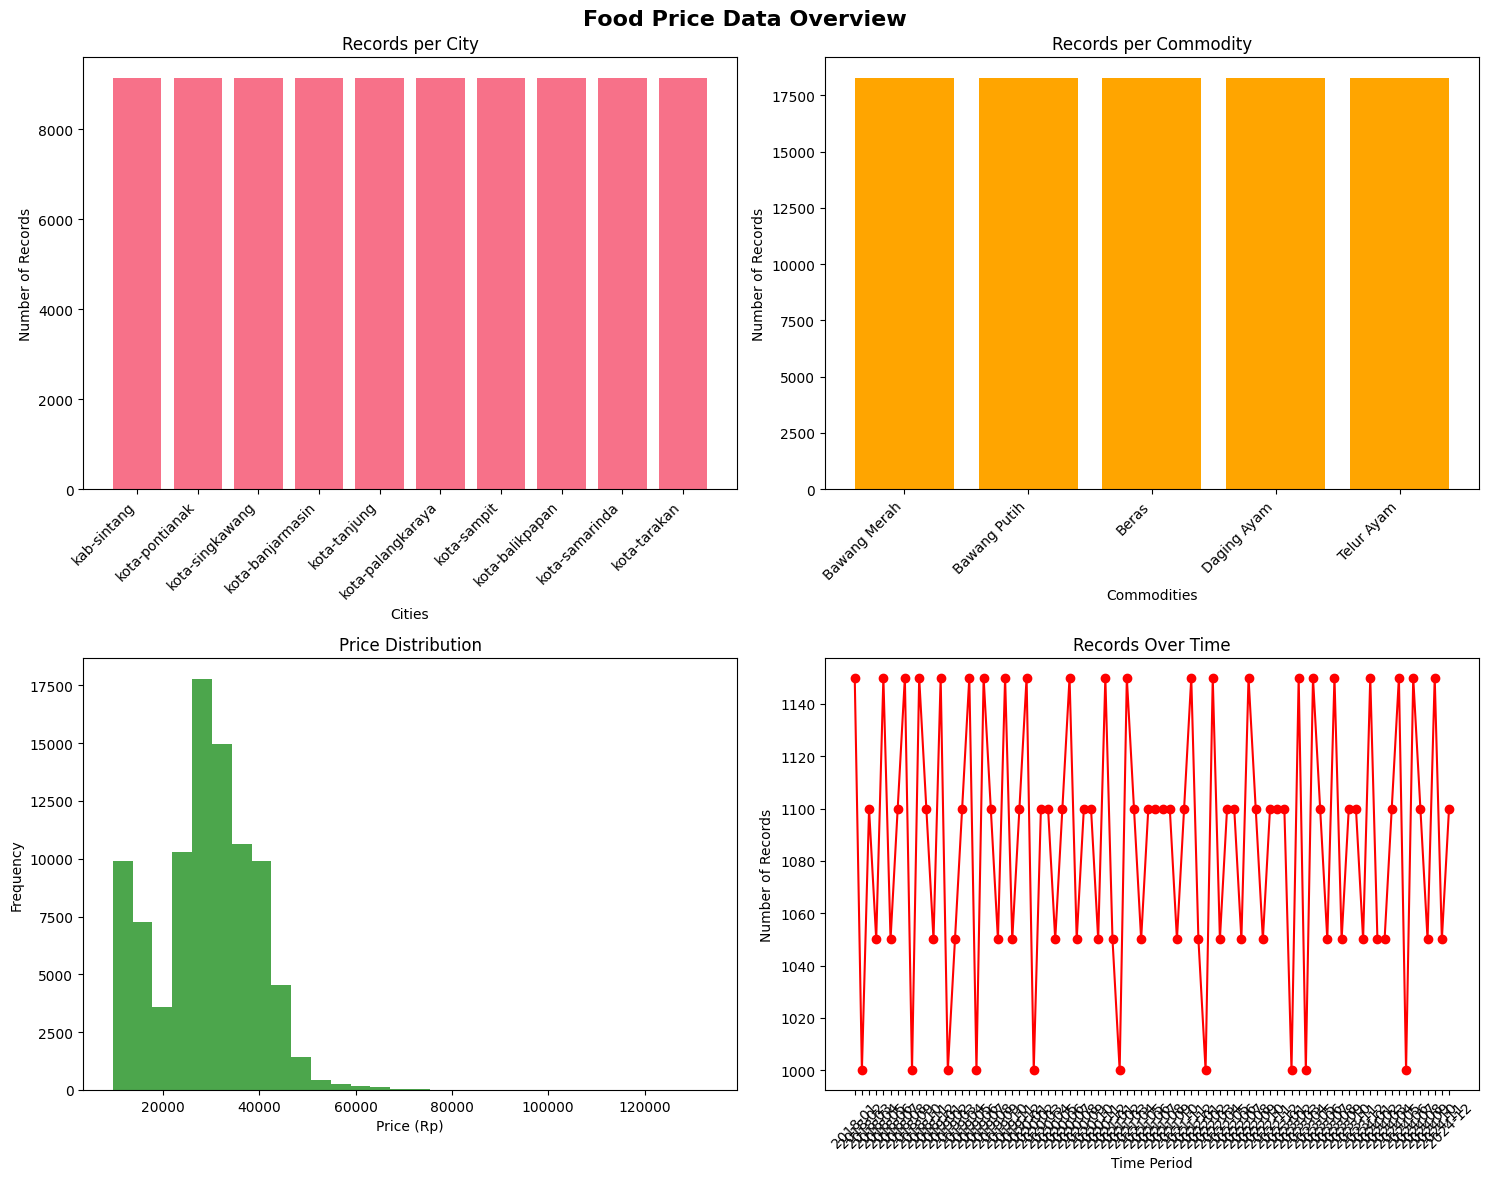


📊 Key Statistics:
   📈 Total Records: 91,350
   🏙️  Number of Cities: 10
   🥘 Number of Commodities: 5
   📅 Date Range: 2018-01-01 00:00:00 to 2024-12-31 00:00:00
   💰 Average Price: Rp 29,093
   💰 Median Price: Rp 29,500


In [10]:
# Create visualizations
if not consolidated_data.empty:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Food Price Data Overview', fontsize=16, fontweight='bold')
    
    # 1. Records per city
    city_counts = consolidated_data['City'].value_counts()
    axes[0, 0].bar(range(len(city_counts)), city_counts.values)
    axes[0, 0].set_title('Records per City')
    axes[0, 0].set_xlabel('Cities')
    axes[0, 0].set_ylabel('Number of Records')
    axes[0, 0].set_xticks(range(len(city_counts)))
    axes[0, 0].set_xticklabels(city_counts.index, rotation=45, ha='right')
    
    # 2. Records per commodity
    commodity_counts = consolidated_data['Commodities'].value_counts()
    axes[0, 1].bar(range(len(commodity_counts)), commodity_counts.values, color='orange')
    axes[0, 1].set_title('Records per Commodity')
    axes[0, 1].set_xlabel('Commodities')
    axes[0, 1].set_ylabel('Number of Records')
    axes[0, 1].set_xticks(range(len(commodity_counts)))
    axes[0, 1].set_xticklabels(commodity_counts.index, rotation=45, ha='right')
    
    # 3. Price distribution
    axes[1, 0].hist(consolidated_data['Price'], bins=30, alpha=0.7, color='green')
    axes[1, 0].set_title('Price Distribution')
    axes[1, 0].set_xlabel('Price (Rp)')
    axes[1, 0].set_ylabel('Frequency')
    
    # 4. Records over time (if Date column exists)
    if 'Date' in consolidated_data.columns:
        try:
            # Convert Date to datetime if it's not already
            consolidated_data['Date'] = pd.to_datetime(consolidated_data['Date'])
            
            # Group by month-year
            monthly_data = consolidated_data.groupby(consolidated_data['Date'].dt.to_period('M')).size()
            
            axes[1, 1].plot(monthly_data.index.astype(str), monthly_data.values, marker='o', color='red')
            axes[1, 1].set_title('Records Over Time')
            axes[1, 1].set_xlabel('Time Period')
            axes[1, 1].set_ylabel('Number of Records')
            axes[1, 1].tick_params(axis='x', rotation=45)
            
        except Exception as e:
            axes[1, 1].text(0.5, 0.5, f'Date visualization error:\n{str(e)}', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Date Analysis (Error)')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n📊 Key Statistics:")
    print(f"   📈 Total Records: {len(consolidated_data):,}")
    print(f"   🏙️  Number of Cities: {consolidated_data['City'].nunique()}")
    print(f"   🥘 Number of Commodities: {consolidated_data['Commodities'].nunique()}")
    if 'Date' in consolidated_data.columns:
        print(f"   📅 Date Range: {consolidated_data['Date'].min()} to {consolidated_data['Date'].max()}")
    print(f"   💰 Average Price: Rp {consolidated_data['Price'].mean():,.0f}")
    print(f"   💰 Median Price: Rp {consolidated_data['Price'].median():,.0f}")
    
else:
    print("📊 No data available for visualization.")


## 6. Custom Configuration Example 🛠️

Let's demonstrate how to use custom configurations for specific analysis needs:


## 7. Data Quality Analysis 🔍

Let's analyze the quality of our consolidated data:


In [13]:
# Data quality analysis
if not consolidated_data.empty:
    print("🔍 Data Quality Analysis")
    print("=" * 50)
    
    # Get detailed summary using our pipeline's method
    summary = pipeline.get_data_summary(consolidated_data)
    
    print(f"📊 Comprehensive Summary:")
    print(f"   📈 Total Records: {summary['total_records']:,}")
    print(f"   🏙️  Unique Cities: {summary['num_cities']}")
    print(f"   🥘 Unique Commodities: {summary['num_commodities']}")
    print(f"   📅 Unique Dates: {summary['num_unique_dates']}")
    
    print(f"\n🏙️  Cities in Dataset:")
    for city in summary['cities']:
        city_data = consolidated_data[consolidated_data['City'] == city]
        print(f"   • {city}: {len(city_data):,} records")
    
    print(f"\n🥘 Commodities in Dataset:")
    for commodity in summary['commodities']:
        commodity_data = consolidated_data[consolidated_data['Commodities'] == commodity]
        print(f"   • {commodity}: {len(commodity_data):,} records")
    
    # Price statistics
    if 'price_statistics' in summary:
        stats = summary['price_statistics']
        print(f"\n💰 Price Statistics:")
        print(f"   📊 Average: Rp {stats['mean']:,.0f}")
        print(f"   📊 Median: Rp {stats['50%']:,.0f}")
        print(f"   📊 Min: Rp {stats['min']:,.0f}")
        print(f"   📊 Max: Rp {stats['max']:,.0f}")
        print(f"   📊 Standard Deviation: Rp {stats['std']:,.0f}")
    
    # Date range
    if 'date_statistics' in summary:
        date_stats = summary['date_statistics']
        print(f"\n📅 Date Range:")
        print(f"   📅 From: {date_stats['date_range_start']}")
        print(f"   📅 To: {date_stats['date_range_end']}")
        
        # Calculate time span
        time_span = date_stats['date_range_end'] - date_stats['date_range_start']
        print(f"   ⏱️  Span: {time_span.days} days ({time_span.days/365.25:.1f} years)")
    
    # Missing values analysis
    missing_total = sum(summary['missing_values'].values())
    print(f"\n❓ Missing Values Analysis:")
    if missing_total > 0:
        print(f"   ⚠️  Total Missing: {missing_total}")
        for col, count in summary['missing_values'].items():
            if count > 0:
                percentage = (count / len(consolidated_data)) * 100
                print(f"   • {col}: {count} ({percentage:.1f}%)")
    else:
        print(f"   ✅ No missing values found!")
    
    # Data completeness by city-commodity combination
    print(f"\n📊 Data Completeness Matrix:")
    completeness = consolidated_data.groupby(['City', 'Commodities']).size().unstack(fill_value=0)
    if not completeness.empty:
        display(completeness)
    
else:
    print("❌ No data available for quality analysis.")


🔍 Data Quality Analysis
📊 Comprehensive Summary:
   📈 Total Records: 91,350
   🏙️  Unique Cities: 10
   🥘 Unique Commodities: 5
   📅 Unique Dates: 1827

🏙️  Cities in Dataset:
   • kab-sintang: 9,135 records
   • kota-balikpapan: 9,135 records
   • kota-banjarmasin: 9,135 records
   • kota-palangkaraya: 9,135 records
   • kota-pontianak: 9,135 records
   • kota-samarinda: 9,135 records
   • kota-sampit: 9,135 records
   • kota-singkawang: 9,135 records
   • kota-tanjung: 9,135 records
   • kota-tarakan: 9,135 records

🥘 Commodities in Dataset:
   • Bawang Merah: 18,270 records
   • Bawang Putih: 18,270 records
   • Beras: 18,270 records
   • Daging Ayam: 18,270 records
   • Telur Ayam: 18,270 records

💰 Price Statistics:
   📊 Average: Rp 29,093
   📊 Median: Rp 29,500
   📊 Min: Rp 9,600
   📊 Max: Rp 133,000
   📊 Standard Deviation: Rp 10,107

📅 Date Range:
   📅 From: 2018-01-01 00:00:00
   📅 To: 2024-12-31 00:00:00
   ⏱️  Span: 2556 days (7.0 years)

❓ Missing Values Analysis:
   ✅ No m

Commodities,Bawang Merah,Bawang Putih,Beras,Daging Ayam,Telur Ayam
City,,,,,
kab-sintang,1827,1827,1827,1827,1827
kota-balikpapan,1827,1827,1827,1827,1827
kota-banjarmasin,1827,1827,1827,1827,1827
kota-palangkaraya,1827,1827,1827,1827,1827
kota-pontianak,1827,1827,1827,1827,1827
kota-samarinda,1827,1827,1827,1827,1827
kota-sampit,1827,1827,1827,1827,1827
kota-singkawang,1827,1827,1827,1827,1827
kota-tanjung,1827,1827,1827,1827,1827


## 8. Saving Results 💾

Now let's save our consolidated data in different formats:


In [ ]:
# Save the consolidated data
if not consolidated_data.empty:
    print("💾 Saving Consolidated Data")
    print("=" * 50)
    
    # Option 1: Save using the pipeline's built-in method
    save_results = pipeline.consolidator.save_data(
        df=consolidated_data,
        output_dir=pipeline.paths.processed_data_dir
    )
    
    print(f"📊 Save Results:")
    for file_format, success in save_results.items():
        status = "✅ Success" if success else "❌ Failed"
        print(f"   📄 {file_format.upper()}: {status}")
    
    # Option 2: Custom save with specific filenames
    output_dir = Path("data/processed")
    output_dir.mkdir(exist_ok=True)
    
    # Save with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    try:
        # CSV with timestamp
        csv_file = output_dir / f"consolidated_data_{timestamp}.csv"
        consolidated_data.to_csv(csv_file, index=False)
        print(f"   📄 Custom CSV saved: {csv_file}")
        
        # Excel with timestamp
        excel_file = output_dir / f"consolidated_data_{timestamp}.xlsx"
        consolidated_data.to_excel(excel_file, index=False, sheet_name='Consolidated_Data')
        print(f"   📊 Custom Excel saved: {excel_file}")
        
        # Summary statistics to separate file
        summary_file = output_dir / f"summary_statistics_{timestamp}.txt"
        with open(summary_file, 'w') as f:
            f.write("Food Price Data Consolidation Summary\\n")
            f.write("=" * 50 + "\\n")
            f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\\n\\n")
            
            summary = pipeline.get_data_summary(consolidated_data)
            f.write(f"Total Records: {summary['total_records']:,}\\n")
            f.write(f"Cities: {summary['num_cities']}\\n")
            f.write(f"Commodities: {summary['num_commodities']}\\n")
            f.write(f"Unique Dates: {summary['num_unique_dates']}\\n\\n")
            
            f.write("Cities in Dataset:\\n")
            for city in summary['cities']:
                count = len(consolidated_data[consolidated_data['City'] == city])
                f.write(f"  - {city}: {count:,} records\\n")
            
            f.write("\\nCommodities in Dataset:\\n")
            for commodity in summary['commodities']:
                count = len(consolidated_data[consolidated_data['Commodities'] == commodity])
                f.write(f"  - {commodity}: {count:,} records\\n")
        
        print(f"   📋 Summary saved: {summary_file}")
        
    except Exception as e:
        print(f"   ❌ Custom save error: {e}")
    
    print(f"\\n📁 All files saved to: {output_dir.absolute()}")
    
    # List all files in output directory
    print(f"\\n📂 Output Directory Contents:")
    if output_dir.exists():
        for file in sorted(output_dir.glob("*")):
            size_mb = file.stat().st_size / (1024 * 1024)
            print(f"   📄 {file.name} ({size_mb:.2f} MB)")
    
else:
    print("❌ No data to save. Make sure consolidation was successful.")


## 9. Next Steps 🚀

Congratulations! You've successfully consolidated your food price data. Here are the next steps for your analysis:

### 📊 **Immediate Next Steps:**
1. **Explore the data further** - Look for patterns, trends, and anomalies
2. **Clean any remaining issues** - Handle outliers, fix data inconsistencies
3. **Create time series analysis** - Analyze price trends over time

### 🔮 **Future Analysis Pipelines:**
1. **EDA Pipeline** (`02_exploratory_data_analysis.ipynb`) - Deep data exploration
2. **Feature Engineering Pipeline** (`03_feature_engineering.ipynb`) - Create features for clustering
3. **Clustering Pipeline** (`04_clustering_analysis.ipynb`) - Apply clustering algorithms
4. **Results Analysis Pipeline** (`05_results_analysis.ipynb`) - Interpret clustering results

### 💡 **Tips for Success:**
- **Save your work frequently** - Export intermediate results
- **Document your findings** - Add markdown cells with insights
- **Version control configurations** - Save YAML configs for reproducibility
- **Monitor data quality** - Regularly validate new data

### 🛠️ **Useful Commands for Terminal:**
```bash
# Run consolidation with specific config
poetry run python scripts/run_consolidation.py configs/2018_2023.yaml

# Show available configurations
poetry run python scripts/run_consolidation.py --list-configs

# Test configuration without processing
poetry run python scripts/run_consolidation.py configs/my_config.yaml --dry-run
```

### 📚 **Additional Resources:**
- Check `configs/README.md` for configuration examples
- Review the main `README.md` for complete documentation
- Use `--help` on any script for detailed usage information

Happy analyzing! 🎉


In [ ]:
# Final summary and cleanup
print("🎯 Data Consolidation Notebook Summary")
print("=" * 60)
print(f"📅 Notebook completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

if 'consolidated_data' in locals() and not consolidated_data.empty:
    print(f"✅ Successfully processed {len(consolidated_data):,} records")
    print(f"📊 Data shape: {consolidated_data.shape}")
    print(f"🏙️  Cities processed: {consolidated_data['City'].nunique()}")
    print(f"🥘 Commodities processed: {consolidated_data['Commodities'].nunique()}")
    print(f"💾 Files saved to: data/processed/")
else:
    print("⚠️  No data was consolidated - check your data files")

print(f"\\n🚀 System Status: Ready for next analysis phase!")
print(f"📝 Notebook: 01_data_consolidation.ipynb - COMPLETE")
print(f"➡️  Next: 02_exploratory_data_analysis.ipynb")

# Display key variables for reference
print(f"\\n🔧 Key Variables Available:")
print(f"   • consolidated_data: Main dataset ({type(consolidated_data)})")
print(f"   • pipeline: ConsolidationPipeline instance")
print(f"   • config: ConsolidatorConfig with default settings")
print(f"   • paths: PathConfig for directory management")

print(f"\\n💡 Quick Access Commands:")
print(f"   • consolidated_data.head() - View first 5 records")
print(f"   • consolidated_data.info() - Dataset information")
print(f"   • pipeline.get_data_summary(consolidated_data) - Detailed summary")
